In [107]:
import pandas as pd
import datetime
import requests
import json
import sys, os
import itertools
import time
import numpy as np
from os import path
from pathlib import Path
from binance.spot import Spot
from twelvedata import TDClient
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import itertools
import xgboost as xgb
import seaborn as sns
from typing import Union, Dict, List
import talib
import ta
import shap
from coinmetrics.api_client import CoinMetricsClient
sys.path.insert(0, os.path.join(os.getcwd(), ".."))
import fin_utilities 
import sklearn
import scikitplot as skplt
import matplotlib.pyplot as plt
cfg = fin_utilities.__cfg_reading("pred")
import my_functions

import matplotlib as mpl
# Set the default color cycle
mpl.rcParams.update(mpl.rcParamsDefault)


#td = TDClient(apikey=cfg['TWELVEDATA']['API'])  

PROJECT_DIR = eval(cfg['PROJECT_PATH'])
DATA_PATH   = PROJECT_DIR / cfg['DATA_FOLDER']
SOURCE      = cfg['API_DATA_SOURCE']
URL         = cfg[SOURCE]['API_URL_HIST_DATA']
COLUMNS     = cfg[SOURCE]['COLUMN_NAMES']
PARAMS      = cfg[SOURCE]['REQ_PARAMS']
SYMBOL      = cfg['SYMBOL']
STABLECOIN  = cfg['STABLECOIN']
MAX_LENGTH  = cfg['MAX_TRADE_DURATION']
XGB_PARAM   = cfg['xgb']

client = CoinMetricsClient()
print(client)


In [108]:
def extract_values(dict_list, key):
    """
    Extracts the values associated with a given key from a list of dictionaries.

    Args:
        dict_list (list): A list of dictionaries.
        key (str): The key to extract the value from.

    Returns:
        list: A list of values associated with the key.
    """
    values = []
    for dictionary in dict_list:
        if key in dictionary:
            values.append(dictionary[key])
    return values


def create_dict(list1, list2):
    """
    Given two lists, create a dictionary with keys from list1 and values from list2

    Args:
        list1 (list): The list of keys for the dictionary.
        list2 (list): The list of values for the dictionary.

    Returns:
        dict: A dictionary with keys from list1 and values from list2, intercepted with available metrics
    """
    result_dict = {}
    for key in list1:
        result_dict[key] = list(set(extract_values(client.catalog_assets(key)[0]['metrics'], 'metric')) & set(list2))
    return result_dict


In [109]:
SYMBOL = ['btc','eth','bnb','doge','xrp','ada','matic','atom','sol','ltc']

frequency  = "1d"
asset      = SYMBOL
metrics_a = [
    'CapAct1yrUSD',
    'CapMVRVCur',
    'CapMVRVFF',
    'CapMrktCurUSD',
    'CapMrktEstUSD',
    'CapMrktFFUSD',
    'CapRealUSD',
    'AdrActCnt',
    'FeeTotUSD',
    'FeeMeanUSD',
    'DiffLast',
    'DiffMean',
    'NDF',
    'TxCnt',
    'TxCntSec',
    'TxTfrCnt'
]


d = create_dict(SYMBOL, metrics_a)

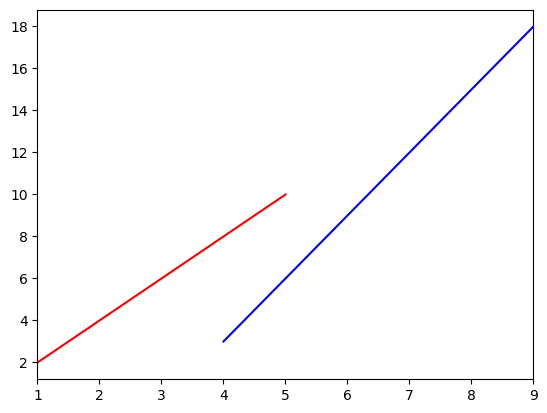

In [110]:
import matplotlib.pyplot as plt

# Data for the first line
x1 = [1, 2, 3, 4, 5]
y1 = [2, 4, 6, 8, 10]

# Data for the second line
x2 = [4, 5, 6, 7, 8, 9]
y2 = [3, 6, 9, 12, 15, 18]

# Create a figure and axis object
fig, ax = plt.subplots()

# Plot the first line
ax.plot(x1, y1, color='red')

# Set the x-axis limits to match the common range
xmin, xmax = min(x1), max(x2)
ax.set_xlim(xmin, xmax)

# Plot the second line
ax.plot(x2, y2, color='blue')

# Show the plot
plt.show()


In [120]:
df_list = []

for asset, metrics_asset in d.items():
    df_list.append(client.get_asset_metrics(
                                    assets    = asset,
                                    metrics   = metrics_asset,
                                    frequency = frequency,
                                    start_time= PARAMS['startTime'],
                                    end_time  = PARAMS['endTime'],
                                    page_size = 10000
                                ).to_dataframe()
    )

df_mcap = pd.concat(df_list, axis=0, ignore_index=True)


#droppo tutte le colonne "status" inutili
df_mcap.drop(columns=[col for col in df_mcap.columns if 'status' in col], inplace=True)
df_mcap = my_functions.round_float_cols(df_mcap)

#replace di tutti i campi None stringa a -1
for col in df_mcap.columns[2:]:
    print(col)
    if len(df_mcap[df_mcap[col]=='None'])!=0:
        df_mcap[col]=df_mcap[col].replace('None','-1')
    else:
        df_mcap[col]=df_mcap[col].fillna(-1)


#df_mcap = df_mcap[df_mcap['AdrActCnt']!=0].reset_index(drop=True)
#df_mcap = df_mcap[df_mcap['AdrActCnt']!=None].reset_index(drop=True)
df_mcap

AdrActCnt
CapAct1yrUSD
CapMVRVCur
CapMVRVFF
CapMrktCurUSD
CapMrktEstUSD
CapMrktFFUSD
CapRealUSD
DiffLast
DiffMean
FeeMeanUSD
FeeTotUSD
NDF
TxCnt
TxCntSec
TxTfrCnt


,asset,time,AdrActCnt,CapAct1yrUSD,CapMVRVCur,CapMVRVFF,CapMrktCurUSD,CapMrktEstUSD,CapMrktFFUSD,CapRealUSD,DiffLast,DiffMean,FeeMeanUSD,FeeTotUSD,NDF,TxCnt,TxCntSec,TxTfrCnt
0,btc,2009-01-03 00:00:00+00:00,0,-1,-1,-1,-1,-1,-1,0.0,-1,-1,-1,-1,-1,0,0.0,0
1,btc,2009-01-04 00:00:00+00:00,0,-1,-1,-1,-1,-1,-1,0.0,-1,-1,-1,-1,-1,0,0.0,0
2,btc,2009-01-05 00:00:00+00:00,0,-1,-1,-1,-1,-1,-1,0.0,-1,-1,-1,-1,-1,0,0.0,0
3,btc,2009-01-06 00:00:00+00:00,0,-1,-1,-1,-1,-1,-1,0.0,-1,-1,-1,-1,-1,0,0.0,0
4,btc,2009-01-07 00:00:00+00:00,0,-1,-1,-1,-1,-1,-1,0.0,-1,-1,-1,-1,-1,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26810,ltc,2023-02-13 00:00:00+00:00,246078,3147269483.057723636097559054408,0.967869535216,0.859112115891,6582489164.256344701065131429004,6581828736.79195814719574263226,5842829005.333388157167197694252,6801008735.94424,24131309.40807234,24131309.40807234,0.01146654969592895918,1226.649145848652091092022,0.660407122645,106976,1.238148,259571
26811,ltc,2023-02-14 00:00:00+00:00,271298,3301476124.939025841280318352216,1.014137305732,0.899967220365,6913361543.895511753064860351304,6912620169.54595184937816835676,6135065475.721465225205909366228,6816987704.546351,24131309.40807234,24131309.40807234,0.011760472842895194592,1237.754704322563432585932,0.660044968836,105244,1.218102,284329
26812,ltc,2023-02-15 00:00:00+00:00,276313,3546647347.6787442325987009204,1.085411831485,0.962957000774,7426494117.0231433669914153012,7425747876.692046896086968678,6588646165.2152733416708676804,6842097995.98622,24479457.87732383,24153259.22399713,0.0147135099598403532,1378.9176557082278732842,0.660501868436,93715,1.084664,253667
26813,ltc,2023-02-16 00:00:00+00:00,235755,3428047808.550585197820784797328,1.049592254684,0.930850605782,7175225558.364478951820203315046,7174505877.16907383734203894349,6363483560.229450109192793984368,6836202845.763253,24479457.87732383,24479457.87732383,0.013012414070311551203,1242.746892914916532322322,0.660899383831,95508,1.105417,254075


In [121]:
# EXPORT DI TUTTI I DATI DA TUTTI GLI EXCHANGE
from typing import Optional
import logging

logger = logging.getLogger()
stream_handler = logging.StreamHandler()
level = logging.getLevelName("INFO")
stream_handler.level = level
formatter = logging.Formatter(
    datefmt="[%Y-%m-%d %H:%M:%S]", fmt="%(asctime)-15s %(levelname)s %(message)s"
)
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)
logger.level = level

# use it if you want to get specific exchanges or leave it empty if you want to get all exchanges data
EXCHANGES_TO_EXPORT = {}

# use it if you want to get specific markets or leave it empty if you want to get all markets
# example of market name to be used in this filter: "binance-BTCUSDT-future",
# note that if you specified exchanges filter, it will act as selecting intersection with the markets to export
# not as union.
MARKETS_TO_EXPORT = {}

# example values: "spot", "future", "option"
# you can use all 3 if you want or just a subset
MARKET_TYPES_TO_COLLECT = {
    "spot"   
}

# leave it empty to catch all
BASE_MARKETS = {
    "btc",
}

# leave it empty to catch all
QUOTE_MARKETS = {
    "usdt",
}

# 1m, 5m, 10m, 15m, 30m, 1h, 4h, 1d
FREQUENCY = "1d"

DST_ROOT = "./data"
EXPORT_START_DATE = "2009-01-01"
EXPORT_END_DATE: Optional[str] = None
# path to local file that is used to not reexport data if it was already exported
PROCESSED_DAYS_REGISTRY_FILE_PATH = "candles_processed_days_registry.txt"

client = CoinMetricsClient()

if __name__ == "__main__":
    export_start_time = datetime.datetime.now()
    try:
        my_functions.export_data(
                client,
                PROCESSED_DAYS_REGISTRY_FILE_PATH, 
                EXCHANGES_TO_EXPORT,
                MARKETS_TO_EXPORT,
                MARKET_TYPES_TO_COLLECT,
                BASE_MARKETS,
                QUOTE_MARKETS,
                EXPORT_START_DATE,
                str(datetime.datetime.now().date()), 
                DST_ROOT, 
                FREQUENCY 
        )
    finally:
        print("export took: %s", datetime.datetime.now() - export_start_time)


mkts = my_functions.get_markets_to_process(client,EXCHANGES_TO_EXPORT, MARKETS_TO_EXPORT, MARKET_TYPES_TO_COLLECT, BASE_MARKETS, QUOTE_MARKETS)

df = pd.DataFrame()

for mkt in mkts:
    print(mkt) 
    
    market_data_root = "/".join(                                                                                                                                    
                (                                                                                                                                                        
                    DST_ROOT.rstrip("/"),                                                                                                                                
                    mkt["market"].split("-")[0],                                                                                                                         
                    my_functions.get_instrument_root(mkt),                                                                                                                            
                ) 
    )      
    print(f'manng {my_functions.get_instrument_root(mkt)}')

    df = pd.concat([df,
                    my_functions.read_data_for_a_market(
                                market_data_root,                                                                                                                                                               
                                FREQUENCY                                         
                            )
                    ],
                     ignore_index=True)       

#max volums for each day between all the exchanges
df = df[df['volume'] == df.groupby('time')['volume'].transform('max')].sort_values(by='time').reset_index(drop=True)
df['time'] = pd.to_datetime(df['time']).dt.date
df['time'] = pd.to_datetime(df['time'])
df['market'] = df['market'].str.split('-',2, expand=True)[1]
df.head(5)

getting markets: %s ['bibox-btc-usdt-spot', 'binance-btc-usdt-spot', 'binance.us-btc-usdt-spot', 'bitfinex-btc-usdt-spot', 'bitstamp-btc-usdt-spot', 'bittrex-btc-usdt-spot', 'bybit-btc-usdt-spot', 'cex.io-btc-usdt-spot', 'coinbase-btc-usdt-spot', 'crypto.com-btc-usdt-spot', 'gate.io-btc-usdt-spot', 'gemini-btc-usdt-spot', 'hitbtc-btc-usdt-spot', 'huobi-btc-usdt-spot', 'kraken-btc-usdt-spot', 'kucoin-btc-usdt-spot', 'lbank-btc-usdt-spot', 'liquid-btc-usdt-spot', 'localbitcoins-btc-usdt-spot', 'mexc-btc-usdt-spot', 'okex-btc-usdt-spot', 'poloniex-btc-usdt-spot', 'therocktrading-btc-usdt-spot', 'upbit-btc-usdt-spot', 'zb.com-btc-usdt-spot']
export took: %s 0:00:01.298618
{'market': 'bibox-btc-usdt-spot', 'min_time': '2023-03-17T20:49:32.000000000Z', 'max_time': '2023-03-18T20:40:17.835000000Z', 'exchange': 'bibox', 'type': 'spot', 'trades': {'min_time': '2023-03-17T20:49:32.000000000Z', 'max_time': '2023-03-18T20:40:17.835000000Z'}, 'base': 'btc', 'quote': 'usdt', 'symbol': 'BTC_USDT'}
ma

In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.


,market,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count
0,btc,2013-12-27,777.00,742.43,779.00,694.84,719.137959,1679.63,1.203333e+06,3052
1,btc,2013-12-28,710.46,732.42,752.42,672.80,723.941888,4583.78,3.304529e+06,8343
2,btc,2013-12-29,699.61,746.28,750.01,690.50,716.646226,4718.43,3.373881e+06,8617
3,btc,2013-12-30,715.05,721.52,758.58,710.40,736.373543,4824.67,3.539129e+06,8838
4,btc,2013-12-31,721.99,722.58,756.09,698.17,732.001148,4821.72,3.512753e+06,8748


In [122]:
dxy = pd.read_csv('data/DXY.csv')
dxy = dxy[['Date','Adj Close']]
dxy['Date'] = pd.to_datetime(dxy['Date'])
#inserisco date mancanti
dxy = pd.merge(pd.Series(pd.date_range(dxy['Date'].min(),dxy['Date'].max(),freq='d'), name='Date'), dxy, on='Date', how='left').reset_index(drop=True)
dxy['Dxy_Close'] = np.round(dxy['Adj Close'].ffill(),2)
dxy.drop(columns='Adj Close', inplace=True)
df = pd.merge(df,dxy,left_on='time',right_on='Date',how='left')
df.drop(columns=['Date'],inplace=True)
df

,market,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count,Dxy_Close
0,btc,2013-12-27,777.00,742.43,779.00,694.84,719.137959,1679.63000,1.203333e+06,3052,80.39
1,btc,2013-12-28,710.46,732.42,752.42,672.80,723.941888,4583.78000,3.304529e+06,8343,80.39
2,btc,2013-12-29,699.61,746.28,750.01,690.50,716.646226,4718.43000,3.373881e+06,8617,80.39
3,btc,2013-12-30,715.05,721.52,758.58,710.40,736.373543,4824.67000,3.539129e+06,8838,80.00
4,btc,2013-12-31,721.99,722.58,756.09,698.17,732.001148,4821.72000,3.512753e+06,8748,80.04
...,...,...,...,...,...,...,...,...,...,...,...
3334,btc,2023-02-12,21862.02,21783.54,22090.00,21630.00,21864.202285,204435.65163,4.470708e+09,4561903,103.63
3335,btc,2023-02-13,21782.37,21773.97,21894.99,21351.07,21657.583360,295730.76791,6.409556e+09,6503611,103.35
3336,btc,2023-02-14,21774.63,22199.84,22319.08,21532.77,21931.761918,361958.40109,7.942328e+09,7695927,103.23
3337,btc,2023-02-15,22199.84,24324.05,24380.00,22047.28,22903.486856,375669.16111,8.604291e+09,8335550,103.92


In [123]:
print(df.columns)
map_ohlc = {'Open':'price_open','High':'price_high','Low':'price_low','Close':'price_close', 'Volume': 'volume', 'Number of trades': 'candle_trades_count'}
df['AVG_Candle_Price'] = (df[map_ohlc['Open']]+df[map_ohlc['High']]+df[map_ohlc['Low']]+df[map_ohlc['Close']])/4
df['SMA_AVG_Candle_Price_13d'] = my_functions.rolling_kpi(df,'AVG_Candle_Price',13,'mean', False)
df['VAR_AVG_Candle_Price_13d'] = (df['AVG_Candle_Price'] - df['SMA_AVG_Candle_Price_13d'])**2
df['SMA_AVG_Candle_Price_50d'] = my_functions.rolling_kpi(df,'AVG_Candle_Price',50,'mean', False)
#df['SMA_AVG_Candle_Price_100d'] = my_functions.rolling_kpi(df,'AVG_Candle_Price',100,'mean', False)
df['SMA_AVG_Candle_Price_200d'] = my_functions.rolling_kpi(df,'AVG_Candle_Price',200,'mean', False)
df['EMA_VOL_13d'] = df[map_ohlc['Volume']].ewm(span=13, adjust=False).mean()
df['EMA_VOL_50d'] = df[map_ohlc['Volume']].ewm(span=50, adjust=False).mean()
#df['EMA_VOL_100d'] = df[map_ohlc['Volume']].ewm(span=100, adjust=False).mean()
df['EMA_VOL_200d'] = df[map_ohlc['Volume']].ewm(span=200, adjust=False).mean()
df['STD_VOL_13d'] = (df[map_ohlc['Volume']] - df['EMA_VOL_13d'])**2 
df['STD_VOL_50d'] = (df[map_ohlc['Volume']] - df['EMA_VOL_50d'])**2 
#df['STD_VOL_100d'] = (df[map_ohlc['Volume']] - df['EMA_VOL_100d'])**2 
df['STD_VOL_200d'] = (df[map_ohlc['Volume']] - df['EMA_VOL_200d'])**2 
df['PCT_Change'] = df[map_ohlc['Close']].pct_change()
# Calculate the mean and standard deviation of the daily returns
mean_return = df['PCT_Change'].mean()
std_return = df['PCT_Change'].std()
# Calculate the risk-free rate
risk_free_rate = 0.01
# Calculate the Sharpe ratio
df['Sharpe_Ratio'] = (mean_return - risk_free_rate) / std_return
df['Log_Ret'] = np.log(1 + df['PCT_Change'])
df['Log_Ret_13d'] = np.log(1+ df['PCT_Change']) - np.log(df['PCT_Change'].shift(13))
df['Excursion'] = df[map_ohlc['High']]-df[map_ohlc['Low']]
df['PCT_Excursion'] = df['Excursion'].pct_change()
df['DELTA_NTrades'] = df[map_ohlc['Number of trades']]- df[map_ohlc['Number of trades']].shift()
#Volume-price trend:
df['VP_trend'] = df[map_ohlc['Volume']] * df[map_ohlc['Close']].pct_change()
#On-balance volume
df['OBV'] = np.where(df[map_ohlc['Close']] > df[map_ohlc['Close']].shift(1), df[map_ohlc['Volume']], - df[map_ohlc['Volume']])
df['OBV'] = df['OBV'].cumsum()
#VWAP
df['VWAP'] = (df[map_ohlc['Close']] * df[map_ohlc['Volume']]).cumsum() / df[map_ohlc['Volume']].cumsum()
#Volume Rate Of Change
df['Volume_ROC'] =df[map_ohlc['Volume']].pct_change()
#Volume-price trend divergence:
df['VP_divergence'] = df[map_ohlc['Volume']].rolling(window=10).mean() - df[map_ohlc['Close']].rolling(window=10).mean()
#Chaikin Money Flow
df["chaikin_money_flow"] = ((df[map_ohlc['Close']] - df[map_ohlc['Low']]) - (df[map_ohlc['High']] - df[map_ohlc['Close']])) / (df[map_ohlc['High']] - df[map_ohlc['Low']]) * df[map_ohlc['Volume']]
# Head and Shoulders
#df['hs_pattern'] = ta.pattern.head_and_shoulders(df['Close'],neck_width=1,trend='down')
# 2 crows or 3 black crows candlestick pattern 
#df['cdl2crows'] = talib.CDL2CROWS(df['Open'],df['High'],df['Low'],df['Close'])
#df['cdl3blackcrows'] = talib.CDL3BLACKCROWS(df['Open'],df['High'],df['Low'],df['Close'])
df['MAX_50d'] = my_functions.rolling_kpi(df,map_ohlc['High'],50, 'max', False)
df['MIN_50d'] = my_functions.rolling_kpi(df,map_ohlc['Low'],50, 'min', False)
# RSI
df['RSI'] = ta.momentum.RSIIndicator(df[map_ohlc['Close']], window=14).rsi()
#BollingerBands
bb = ta.volatility.BollingerBands(df[map_ohlc['Close']], window=20, window_dev=2)
df['BB_upper'] = bb.bollinger_hband()
df['BB_lower'] = bb.bollinger_lband()
#MFI
mfi = ta.volume.MFIIndicator(df[map_ohlc['High']], df[map_ohlc['Low']], df[map_ohlc['Close']], df[map_ohlc['Volume']], window=14)
df['MFI'] = mfi.money_flow_index()
df

Index(['market', 'time', 'price_open', 'price_close', 'price_high',
       'price_low', 'vwap', 'volume', 'candle_usd_volume',
       'candle_trades_count', 'Dxy_Close'],
      dtype='object')


divide by zero encountered in log
invalid value encountered in log


,market,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count,...,VWAP,Volume_ROC,VP_divergence,chaikin_money_flow,MAX_50d,MIN_50d,RSI,BB_upper,BB_lower,MFI
0,btc,2013-12-27,777.00,742.43,779.00,694.84,719.137959,1679.63000,1.203333e+06,3052,...,742.430000,NaN,NaN,219.932540,779.0,694.84,NaN,NaN,NaN,NaN
1,btc,2013-12-28,710.46,732.42,752.42,672.80,723.941888,4583.78000,3.304529e+06,8343,...,735.104336,1.729042,NaN,2280.951565,779.0,672.80,NaN,NaN,NaN,NaN
2,btc,2013-12-29,699.61,746.28,750.01,690.50,716.646226,4718.43000,3.373881e+06,8617,...,739.906044,0.029375,NaN,4126.941380,779.0,672.80,NaN,NaN,NaN,NaN
3,btc,2013-12-30,715.05,721.52,758.58,710.40,736.373543,4824.67000,3.539129e+06,8838,...,734.294015,0.022516,NaN,-2597.591112,779.0,672.80,NaN,NaN,NaN,NaN
4,btc,2013-12-31,721.99,722.58,756.09,698.17,732.001148,4821.72000,3.512753e+06,8748,...,731.555937,-0.000611,NaN,-757.556146,779.0,672.80,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,btc,2023-02-12,21862.02,21783.54,22090.00,21630.00,21864.202285,204435.65163,4.470708e+09,4561903,...,20338.398687,0.154863,245860.209398,-67961.521407,24255.0,16333.00,47.410634,24114.267298,21629.800702,41.752474
3335,btc,2023-02-13,21782.37,21773.97,21894.99,21351.07,21657.583360,295730.76791,6.409556e+09,6503611,...,20341.099700,0.446571,242341.976285,164132.968482,24255.0,16333.00,47.309166,24157.800561,21500.375439,42.014099
3336,btc,2023-02-14,21774.63,22199.84,22319.08,21532.77,21931.761918,361958.40109,7.942328e+09,7695927,...,20345.370250,0.223946,262037.869099,252180.019164,24255.0,16333.00,52.210697,24137.514290,21434.551710,43.204328
3337,btc,2023-02-15,22199.84,24324.05,24380.00,22047.28,22903.486856,375669.16111,8.604291e+09,8335550,...,20354.835162,0.037879,278540.537293,357648.404599,24380.0,16333.00,68.133906,24359.175817,21344.330183,44.171168


In [124]:
df = my_functions.labelize_output_according_criterion2(df, map_ohlc, max_trade_length=MAX_LENGTH)
df['signal'] = (df['min_above'].lt(df['min_below'])) & (df['min_above'] <= MAX_LENGTH)
df['signal']=df['signal'].astype(int)
df.drop(columns=['CloseAbovethreshold', 'HighAbovethreshold',
       'LowAbovethreshold', 'OpenAbovethreshold', 'CloseBelowthreshold',
       'HighBelowthreshold', 'LowBelowthreshold', 'OpenBelowthreshold', 'TP',
       'SL', 'min_above', 'min_below'], inplace=True, errors='ignore')
df.tail(10)

,market,time,price_open,price_close,price_high,price_low,vwap,volume,candle_usd_volume,candle_trades_count,...,Volume_ROC,VP_divergence,chaikin_money_flow,MAX_50d,MIN_50d,RSI,BB_upper,BB_lower,MFI,signal
3329,btc,2023-02-07,22762.52,23240.46,23350.25,22745.78,23005.761126,308006.72482,7.085767e+09,8293878,...,0.160662,258642.903544,196120.085887,24255.0,16333.0,63.948704,24063.033871,21892.639129,48.892911,0
3330,btc,2023-02-08,23242.42,22963.00,23452.00,22665.85,23058.168956,280056.30717,6.458257e+09,7896433,...,-0.090746,257157.585057,-68344.212339,24255.0,16333.0,60.096228,23716.742237,22428.071763,40.733753,0
3331,btc,2023-02-09,22961.85,21796.35,23011.39,21688.00,22469.825064,402894.69550,9.054928e+09,9784291,...,0.438620,267309.444486,-336922.245568,24255.0,16333.0,47.216029,23865.769788,22191.958212,39.715908,0
3332,btc,2023-02-10,21797.83,21625.19,21938.16,21451.00,21765.008172,338591.94247,7.371587e+09,6993675,...,-0.159602,274853.697824,-96456.584646,24255.0,16333.0,45.669535,24004.879106,21937.012894,39.340070,1
3333,btc,2023-02-11,21625.19,21862.55,21906.32,21599.78,21703.573111,177021.58433,3.842485e+09,4207940,...,-0.477183,261663.824986,126468.738071,24255.0,16333.0,48.203214,24066.106172,21791.252828,43.332762,1
3334,btc,2023-02-12,21862.02,21783.54,22090.00,21630.00,21864.202285,204435.65163,4.470708e+09,4561903,...,0.154863,245860.209398,-67961.521407,24255.0,16333.0,47.410634,24114.267298,21629.800702,41.752474,0
3335,btc,2023-02-13,21782.37,21773.97,21894.99,21351.07,21657.583360,295730.76791,6.409556e+09,6503611,...,0.446571,242341.976285,164132.968482,24255.0,16333.0,47.309166,24157.800561,21500.375439,42.014099,1
3336,btc,2023-02-14,21774.63,22199.84,22319.08,21532.77,21931.761918,361958.40109,7.942328e+09,7695927,...,0.223946,262037.869099,252180.019164,24255.0,16333.0,52.210697,24137.514290,21434.551710,43.204328,1
3337,btc,2023-02-15,22199.84,24324.05,24380.00,22047.28,22903.486856,375669.16111,8.604291e+09,8335550,...,0.037879,278540.537293,357648.404599,24380.0,16333.0,68.133906,24359.175817,21344.330183,44.171168,0
3338,btc,2023-02-16,24322.87,23517.72,25250.00,23505.25,24606.672872,450080.68366,1.107671e+10,11006793,...,0.198077,296935.924969,-443647.090165,25250.0,16333.0,59.966094,24406.629773,21341.232227,45.473169,0


In [125]:
df_mcap['time'] = pd.to_datetime(df_mcap['time']).dt.date
df_mcap['time'] = pd.to_datetime(df_mcap['time'])
df_btc = pd.merge(df, df_mcap, left_on=['time','market'], right_on=['time','asset'], how='left')
df_btc.drop(columns=['asset','market'], inplace=True)
df_btc['AdrActCnt'] = df_btc['AdrActCnt'].fillna(-1).astype('int32')
df_btc = df_btc[df_btc['AdrActCnt']>0]
df_btc['time'] = pd.to_datetime(df_mcap['time']).dt.date
df_btc = df_btc[~df_btc['signal'].isnull()].reset_index(drop=True)
df_btc = df_btc.replace('None', None)
df_btc[df_btc.columns[1:]] = df_btc[df_btc.columns[1:]].apply(pd.to_numeric)
df_btc = my_functions.round_float_cols(df_btc,2)
df_btc['dow'] = pd.to_datetime(df_btc['time']).dt.dayofweek
df_btc['signal'] = df_btc.pop('signal')
df_btc.tail(10).T

,3329,3330,3331,3332,3333,3334,3335,3336,3337,3338
time,2018-02-14,2018-02-15,2018-02-16,2018-02-17,2018-02-18,2018-02-19,2018-02-20,2018-02-21,2018-02-22,2018-02-23
price_open,22762.52,23242.42,22961.85,21797.83,21625.19,21862.02,21782.37,21774.63,22199.84,24322.87
price_close,23240.46,22963.0,21796.35,21625.19,21862.55,21783.54,21773.97,22199.84,24324.05,23517.72
price_high,23350.25,23452.0,23011.39,21938.16,21906.32,22090.0,21894.99,22319.08,24380.0,25250.0
price_low,22745.78,22665.85,21688.0,21451.0,21599.78,21630.0,21351.07,21532.77,22047.28,23505.25
vwap,23005.76,23058.17,22469.83,21765.01,21703.57,21864.2,21657.58,21931.76,22903.49,24606.67
volume,308006.72,280056.31,402894.7,338591.94,177021.58,204435.65,295730.77,361958.4,375669.16,450080.68
candle_usd_volume,7085767324.36,6458257025.24,9054927950.77,7371587225.41,3842485199.44,4470708421.37,6409555707.3,7942327561.1,8604291433.799999,11076706459.43
candle_trades_count,8293878,7896433,9784291,6993675,4207940,4561903,6503611,7695927,8335550,11006793
Dxy_Close,103.43,103.41,103.22,103.63,103.63,103.63,103.35,103.23,103.92,103.86


In [126]:
#df_btc['SMA_Candle_Price_7d'] =  my_functions.rolling_kpi(df_btc,'AVG_Candle_Price',7,'mean', False)
#for col in df_btc.columns[1:-1]:
#    df_btc[col] = df_btc[col] - df_btc[col].shift()

df_btc.drop(columns=['price_open','price_close','price_high','price_low'], inplace=True)

In [127]:
df_btc

,time,vwap,volume,candle_usd_volume,candle_trades_count,Dxy_Close,AVG_Candle_Price,SMA_AVG_Candle_Price_13d,VAR_AVG_Candle_Price_13d,SMA_AVG_Candle_Price_50d,...,DiffLast,DiffMean,FeeMeanUSD,FeeTotUSD,NDF,TxCnt,TxCntSec,TxTfrCnt,dow,signal
0,2009-01-03,719.14,1679.63,1.203333e+06,3052,80.39,748.32,748.32,0.00,748.32,...,1.180923e+09,1.180923e+09,0.17,9068.84,0.41,53496,0.62,136699,5,0
1,2009-01-04,723.94,4583.78,3.304529e+06,8343,80.39,717.03,732.67,244.81,732.67,...,1.180923e+09,1.180923e+09,0.18,8186.40,0.41,46692,0.54,116433,6,0
2,2009-01-05,716.65,4718.43,3.373881e+06,8617,80.39,721.60,728.98,54.48,728.98,...,1.180923e+09,1.180923e+09,0.20,10467.65,0.41,51159,0.59,121618,0,0
3,2009-01-06,736.37,4824.67,3.539129e+06,8838,80.00,726.39,728.33,3.78,728.33,...,1.180923e+09,1.180923e+09,0.16,8602.56,0.41,54952,0.64,159652,1,0
4,2009-01-07,732.00,4821.72,3.512753e+06,8748,80.04,724.71,727.61,8.41,727.61,...,1.180923e+09,1.180923e+09,0.17,8037.80,0.41,48534,0.56,123627,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3334,2018-02-19,21864.20,204435.65,4.470708e+09,4561903,103.63,21841.39,22820.55,958760.71,20301.36,...,3.915640e+13,3.922125e+13,1.58,404245.66,0.32,256348,2.97,719393,0,0
3335,2018-02-20,21657.58,295730.77,6.409556e+09,6503611,103.35,21700.60,22720.84,1040897.90,20399.14,...,3.915640e+13,3.915640e+13,1.78,530883.53,0.32,297879,3.45,786149,1,1
3336,2018-02-21,21931.76,361958.40,7.942328e+09,7695927,103.23,21956.58,22613.07,430976.34,20500.83,...,3.915640e+13,3.915640e+13,1.92,585236.48,0.32,305330,3.53,807858,2,1
3337,2018-02-22,22903.49,375669.16,8.604291e+09,8335550,103.92,23237.79,22576.77,436949.73,20629.63,...,3.915640e+13,3.915640e+13,2.64,859326.93,0.32,325059,3.76,861515,3,0


In [128]:
date_field = 'time'
dt_threshold = df_btc.iloc[-100][date_field]

train, test = my_functions.split_train_validation(df_btc,date_field, dt_threshold )
train.drop(columns=[date_field], inplace=True)
test.drop(columns=[date_field], inplace=True)

In [129]:
test

,vwap,volume,candle_usd_volume,candle_trades_count,Dxy_Close,AVG_Candle_Price,SMA_AVG_Candle_Price_13d,VAR_AVG_Candle_Price_13d,SMA_AVG_Candle_Price_50d,SMA_AVG_Candle_Price_200d,...,DiffLast,DiffMean,FeeMeanUSD,FeeTotUSD,NDF,TxCnt,TxCntSec,TxTfrCnt,dow,signal
0,16966.59,608448.36,9.994829e+09,12719887,108.21,16869.27,20015.00,9895625.70,19582.16,23587.29,...,3.676220e+13,3.676220e+13,1.43,422656.21,0.34,294575,3.41,939361,4,0
1,17088.62,393552.86,6.707559e+09,9900073,106.29,17182.34,19739.79,6540546.57,19546.96,23474.83,...,3.676220e+13,3.676220e+13,1.29,360668.50,0.34,278829,3.23,887619,5,0
2,16850.98,167819.96,2.821603e+09,5046837,106.29,16908.14,19446.50,6443305.66,19501.51,23363.08,...,3.676220e+13,3.676220e+13,1.14,279919.57,0.33,245106,2.84,835277,6,0
3,16621.25,184960.79,3.069510e+09,5382834,106.29,16581.57,19141.20,6551694.91,19451.49,23252.60,...,3.676220e+13,3.676220e+13,1.18,266465.99,0.33,224942,2.60,777748,0,0
4,16501.16,380210.78,6.263375e+09,9215128,106.66,16489.11,18832.57,5491804.77,19403.58,23137.26,...,3.676220e+13,3.676220e+13,1.58,386755.11,0.33,244858,2.83,792051,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,21864.20,204435.65,4.470708e+09,4561903,103.63,21841.39,22820.55,958760.71,20301.36,19726.48,...,3.915640e+13,3.922125e+13,1.58,404245.66,0.32,256348,2.97,719393,0,0
95,21657.58,295730.77,6.409556e+09,6503611,103.35,21700.60,22720.84,1040897.90,20399.14,19718.01,...,3.915640e+13,3.915640e+13,1.78,530883.53,0.32,297879,3.45,786149,1,1
96,21931.76,361958.40,7.942328e+09,7695927,103.23,21956.58,22613.07,430976.34,20500.83,19708.45,...,3.915640e+13,3.915640e+13,1.92,585236.48,0.32,305330,3.53,807858,2,1
97,22903.49,375669.16,8.604291e+09,8335550,103.92,23237.79,22576.77,436949.73,20629.63,19705.15,...,3.915640e+13,3.915640e+13,2.64,859326.93,0.32,325059,3.76,861515,3,0


In [130]:
def weighted_binary_cross_entropy(label, pred):
    # assign the value of imbalanced alpha
    imbalance_alpha = 72
    # compute the prediction with sigmoid
    sigmoid_pred = 1.0 / (1.0 + np.exp(-pred))
    # gradient
    grad = -(imbalance_alpha ** label) * (label - sigmoid_pred)
    hess = (imbalance_alpha ** label) * sigmoid_pred * (1.0 - sigmoid_pred)

    return grad, hess

tscv = TimeSeriesSplit(
        gap=0, 
        #max_train_size=150, 
        n_splits=20, 
        test_size=100
    )

p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
#    'lambda':1.2,
#    'max_depth':7,
    'objective':'binary:logistic',
    'colsample_bytree': .8,
#    'eta':0.05,
    'n_estimators':3000,
#    'early_stopping_rounds':100
    }

model = my_functions.model_selection('xgb',p)
#model.set_params(objective = weighted_binary_cross_entropy)

print(model.get_params())
#train.drop(columns=['price_open', 'price_close', 'price_high', 'price_low'], inplace=True, errors='ignore')
#test.drop(columns=['price_open', 'price_close', 'price_high', 'price_low'], inplace=True, errors='ignore')

for train_index, val_index in tscv.split(train):
    print(f'Train index:{train_index[0]}:{train_index[-1]}, Val index:{val_index[0]}:{val_index[-1]}')
    train_features, train_labels    = my_functions.split_target_features(train.loc[train_index],cfg['TARGET_VARIABLE'])
    val_features, val_labels        = my_functions.split_target_features(train.loc[val_index],cfg['TARGET_VARIABLE'])
    model.fit(train_features, train_labels, eval_set = [(train_features, train_labels), (val_features, val_labels)], verbose=0)
    predictions = model.predict_proba(val_features)[:,1]
    fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(val_labels, predictions)
    print("Test set score: {:.5f}".format(sklearn.metrics.auc(fpr_test, tpr_test)))



{'objective': 'binary:logistic', 'use_label_encoder': None, 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'auc', 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': None, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': None, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 3000, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}
Train index:0:1239, Val index:1240:1339
Test set score: 0.54365
Train index:0:13

In [154]:
def model_selection(
    model_type: str,
    parameter: Dict
) -> xgb.XGBClassifier:
    """
    Instantiate a tree based model
    
     Args:
        model_type: xgb/lgb currently supported
        parameter:  default parameters 
    
    Returns:
        Union[xgb.XGBClassifier, LGBMClassifier]: model instantiated
    """

    dict_model = {
            'xgb': xgb.XGBClassifier(n_jobs=-1, random_state=42)
        }

    return dict_model[model_type].set_params(**parameter)


tscv = TimeSeriesSplit(n_splits=15, test_size=100)
p = {  
    'eval_metric':'auc',
    'tree_method':'hist',
    'max_depth':7,
    'scale_pos_weight':1.2,
    'objective':'binary:logistic',
    'subsample': .8,
    'colsample_bytree': .8,
    'min_child_weight':5,
    'eta':0.05,
    'n_estimators':2000
}

model = model_selection('xgb',p)


for train_index, test_index in tscv.split(train[train.columns[:10]]):
    print(f'Train index:{train_index[0]}:{train_index[-1]}, Val index:{test_index[0]}:{test_index[-1]}')
    train_features, train_labels    = my_functions.split_target_features(train.loc[train_index],cfg['TARGET_VARIABLE'])
    val_features, val_labels        = my_functions.split_target_features(train.loc[test_index],cfg['TARGET_VARIABLE'])
    X_train, X_test = train_features, val_features
    y_train, y_test = train_labels, val_labels

    model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)], verbose=500)
    

Train index:0:1739, Val index:1740:1839
[0]	validation_0-auc:0.82020	validation_1-auc:0.63221
[500]	validation_0-auc:1.00000	validation_1-auc:0.41466
[1000]	validation_0-auc:1.00000	validation_1-auc:0.37941
[1500]	validation_0-auc:1.00000	validation_1-auc:0.37660
[1999]	validation_0-auc:1.00000	validation_1-auc:0.35817
Train index:0:1839, Val index:1840:1939
[0]	validation_0-auc:0.80211	validation_1-auc:0.59538
[500]	validation_0-auc:1.00000	validation_1-auc:0.56703
[1000]	validation_0-auc:1.00000	validation_1-auc:0.56220
[1500]	validation_0-auc:1.00000	validation_1-auc:0.56615
[1999]	validation_0-auc:1.00000	validation_1-auc:0.56879
Train index:0:1939, Val index:1940:2039
[0]	validation_0-auc:0.80492	validation_1-auc:0.47126
[500]	validation_0-auc:1.00000	validation_1-auc:0.68760
[1000]	validation_0-auc:1.00000	validation_1-auc:0.68966
[1500]	validation_0-auc:1.00000	validation_1-auc:0.68637
[1999]	validation_0-auc:1.00000	validation_1-auc:0.69335
Train index:0:2039, Val index:2040:21

In [156]:
y_hat = model.predict_proba(test[test.columns[:-1]])[:,1]
y = test['signal']
df_test= pd.DataFrame({'y':y,'y_hat':y_hat})
df_test = pd.merge(test, df_test, left_index=True, right_index=True)
df_test = df_test[df_test.columns[1:]]
#df_test.sort_values(by=['y_hat'], ascending=False, inplace=True)
#df_test.reset_index(drop=True, inplace=True)
df_test.sort_values(by=['y_hat'], ascending=False)

,volume,candle_usd_volume,candle_trades_count,Dxy_Close,AVG_Candle_Price,SMA_AVG_Candle_Price_13d,VAR_AVG_Candle_Price_13d,SMA_AVG_Candle_Price_50d,SMA_AVG_Candle_Price_200d,EMA_VOL_13d,...,FeeMeanUSD,FeeTotUSD,NDF,TxCnt,TxCntSec,TxTfrCnt,dow,signal,y,y_hat
86,166126.47,3.887452e+09,4852404,102.92,23400.12,23173.73,51252.00,19385.81,19726.79,280325.65,...,1.50,452943.27,0.32,302062,3.50,828676,6,0,0,0.558586
29,238422.06,4.098480e+09,4282003,104.81,17192.72,16865.88,106824.76,18058.56,21099.36,224754.18,...,0.87,233447.14,0.33,268606,3.11,812148,5,1,1,0.506468
51,114490.43,1.896042e+09,3344374,103.52,16565.99,16717.55,22968.16,16790.54,19744.78,160028.30,...,0.83,202108.09,0.32,243946,2.82,759193,6,1,1,0.474179
56,163473.57,2.750303e+09,4842014,105.04,16828.76,16705.38,15220.87,16790.97,19646.83,159560.16,...,0.86,237253.59,0.32,274976,3.18,807190,4,1,1,0.392168
50,164916.31,2.725730e+09,4310415,103.52,16562.82,16732.51,28792.54,16802.86,19772.99,167617.95,...,1.26,360131.60,0.32,286348,3.31,881174,5,1,1,0.315733
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,310790.42,7.212354e+09,7863213,101.22,23357.67,22927.21,185293.99,19024.24,19701.95,282097.87,...,1.49,511697.79,0.32,343824,3.98,890851,3,0,0,0.003841
71,338079.14,7.255403e+09,7382435,102.01,21839.00,19566.48,5164354.14,17603.49,19560.26,281600.60,...,1.53,464548.01,0.32,303214,3.51,878554,5,1,1,0.003803
64,368615.88,7.060991e+09,8021774,102.20,19372.69,17262.51,4452853.95,16977.91,19516.28,247701.66,...,1.04,331866.40,0.32,320370,3.71,910668,5,1,1,0.003408
65,393913.75,8.183829e+09,8659545,102.20,20507.74,17565.31,8657947.50,17057.41,19515.77,268589.10,...,0.94,285374.26,0.32,303624,3.51,849720,6,0,0,0.003334


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


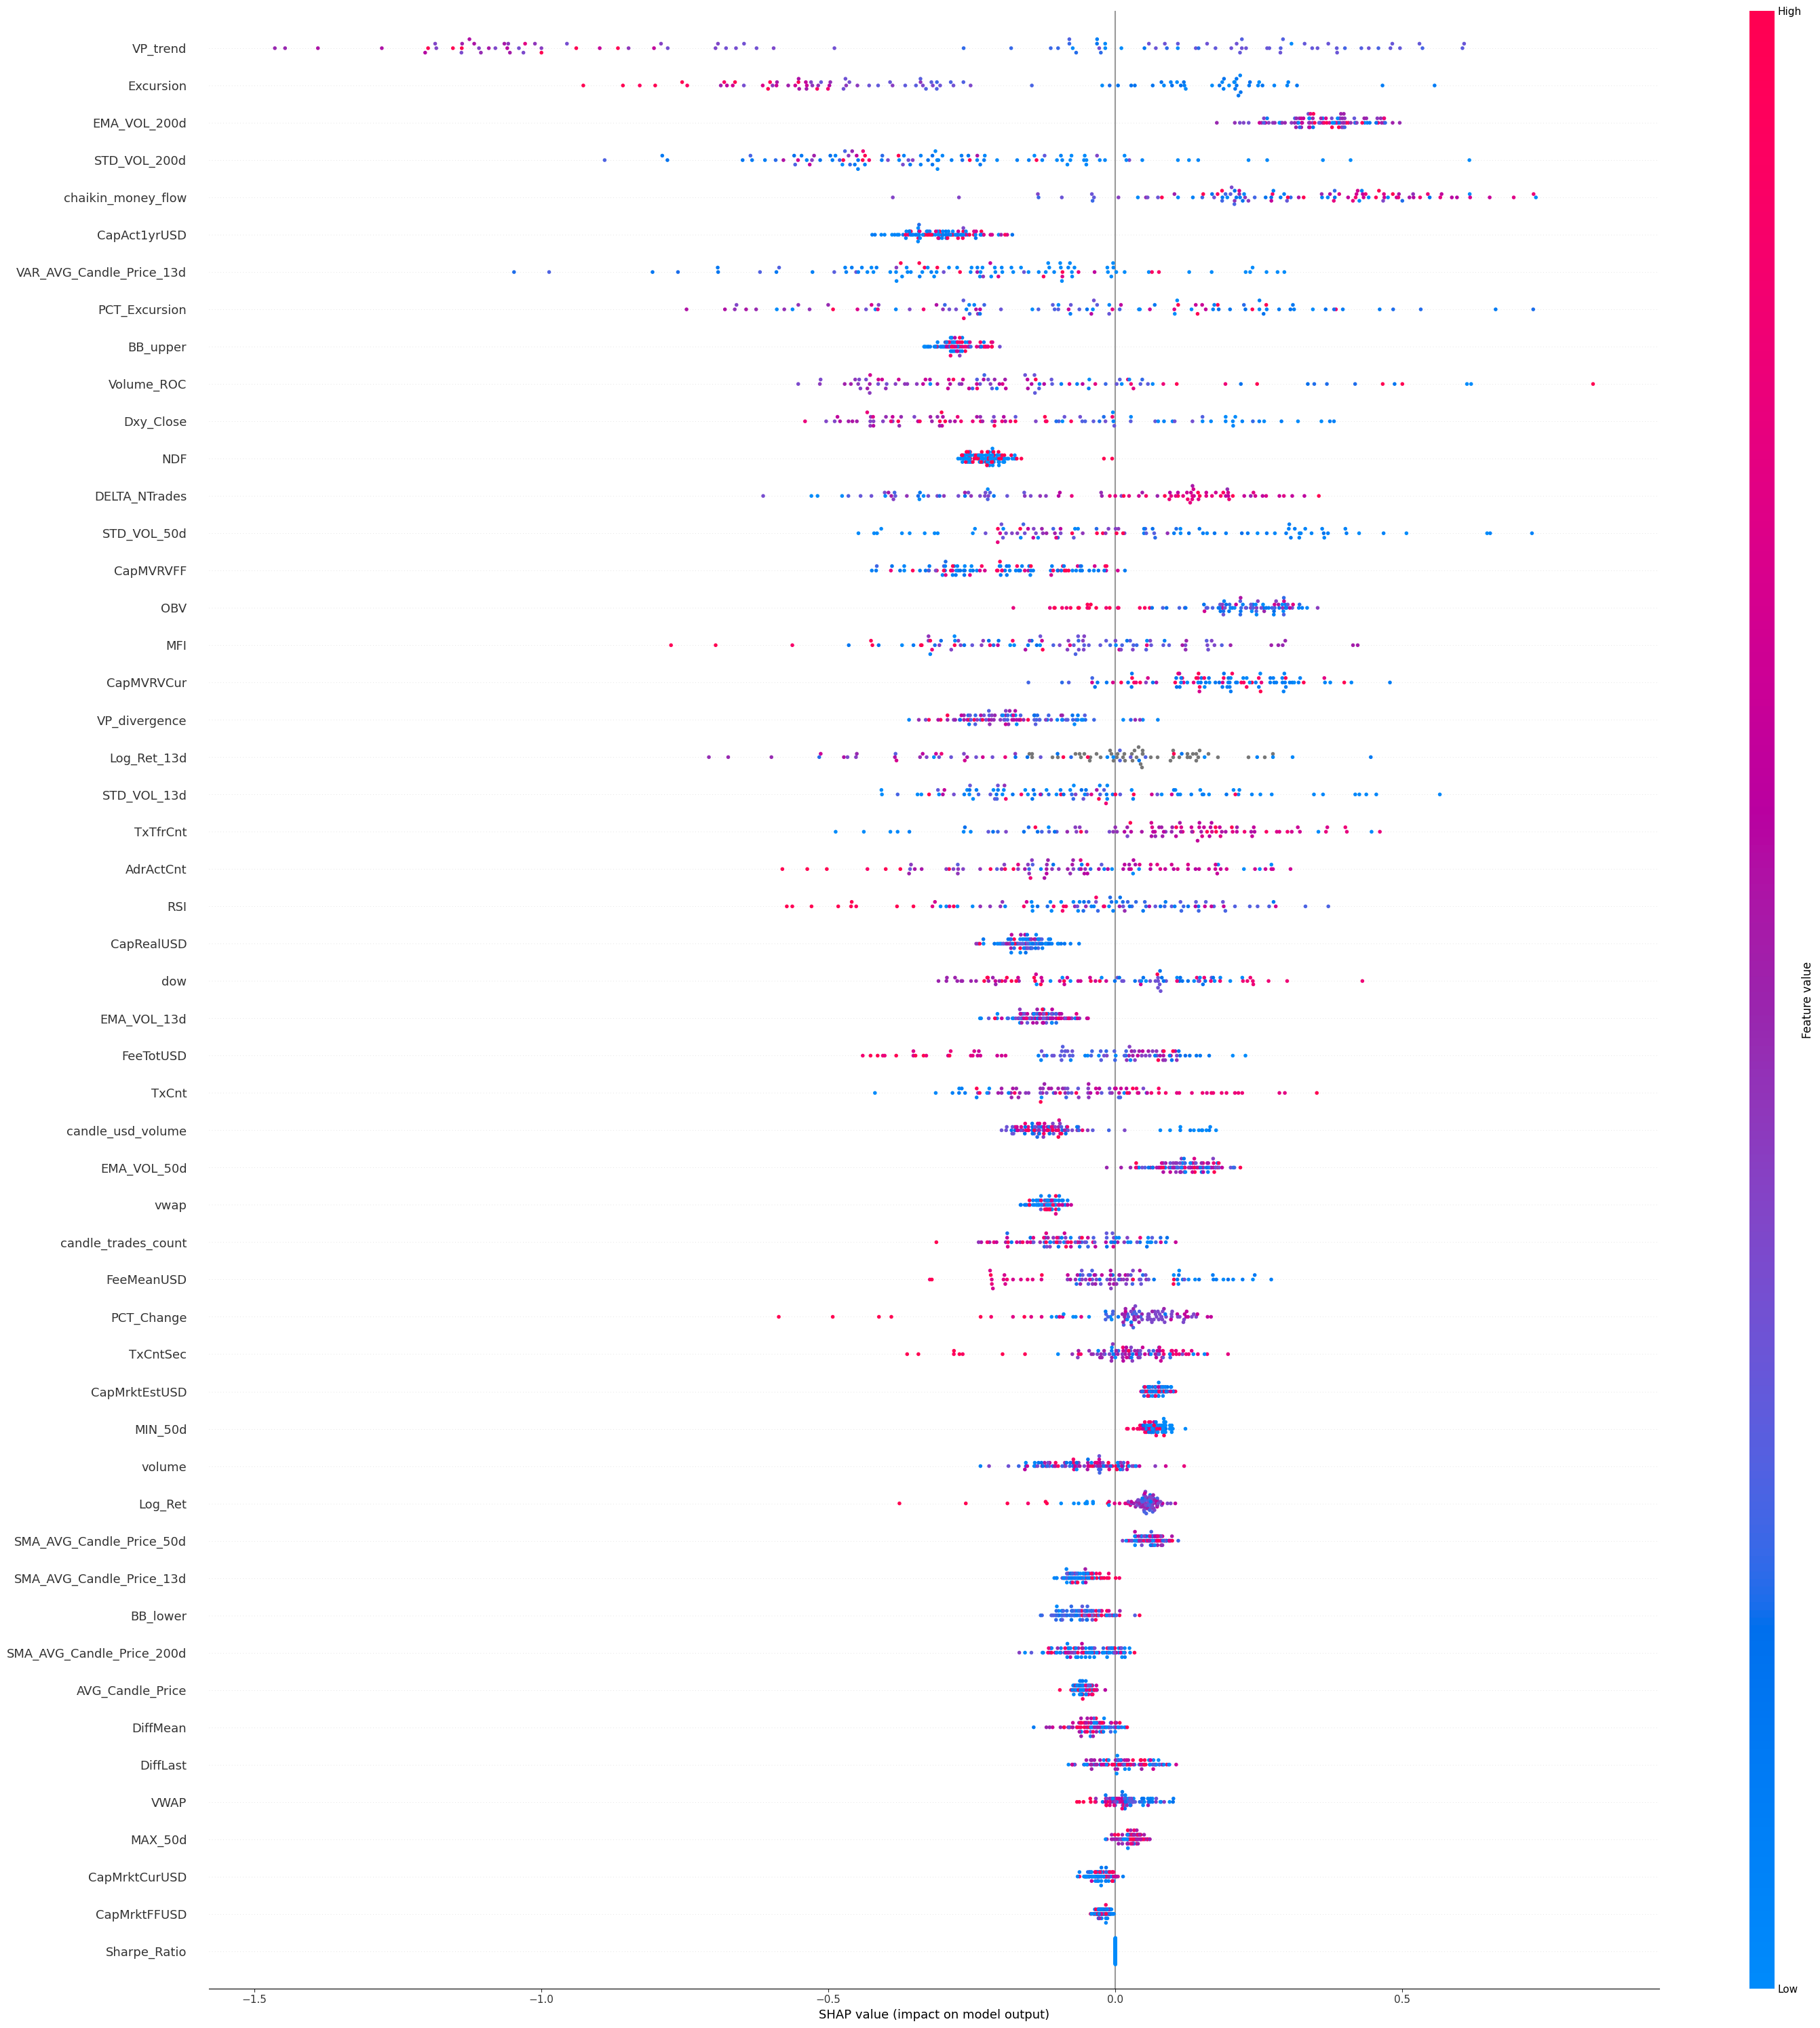

In [157]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(test[test.columns[:-1]])
shap.summary_plot(shap_values, test[test.columns[:-1]], plot_size=[30,30], max_display=len(test[test.columns[:-1]]))

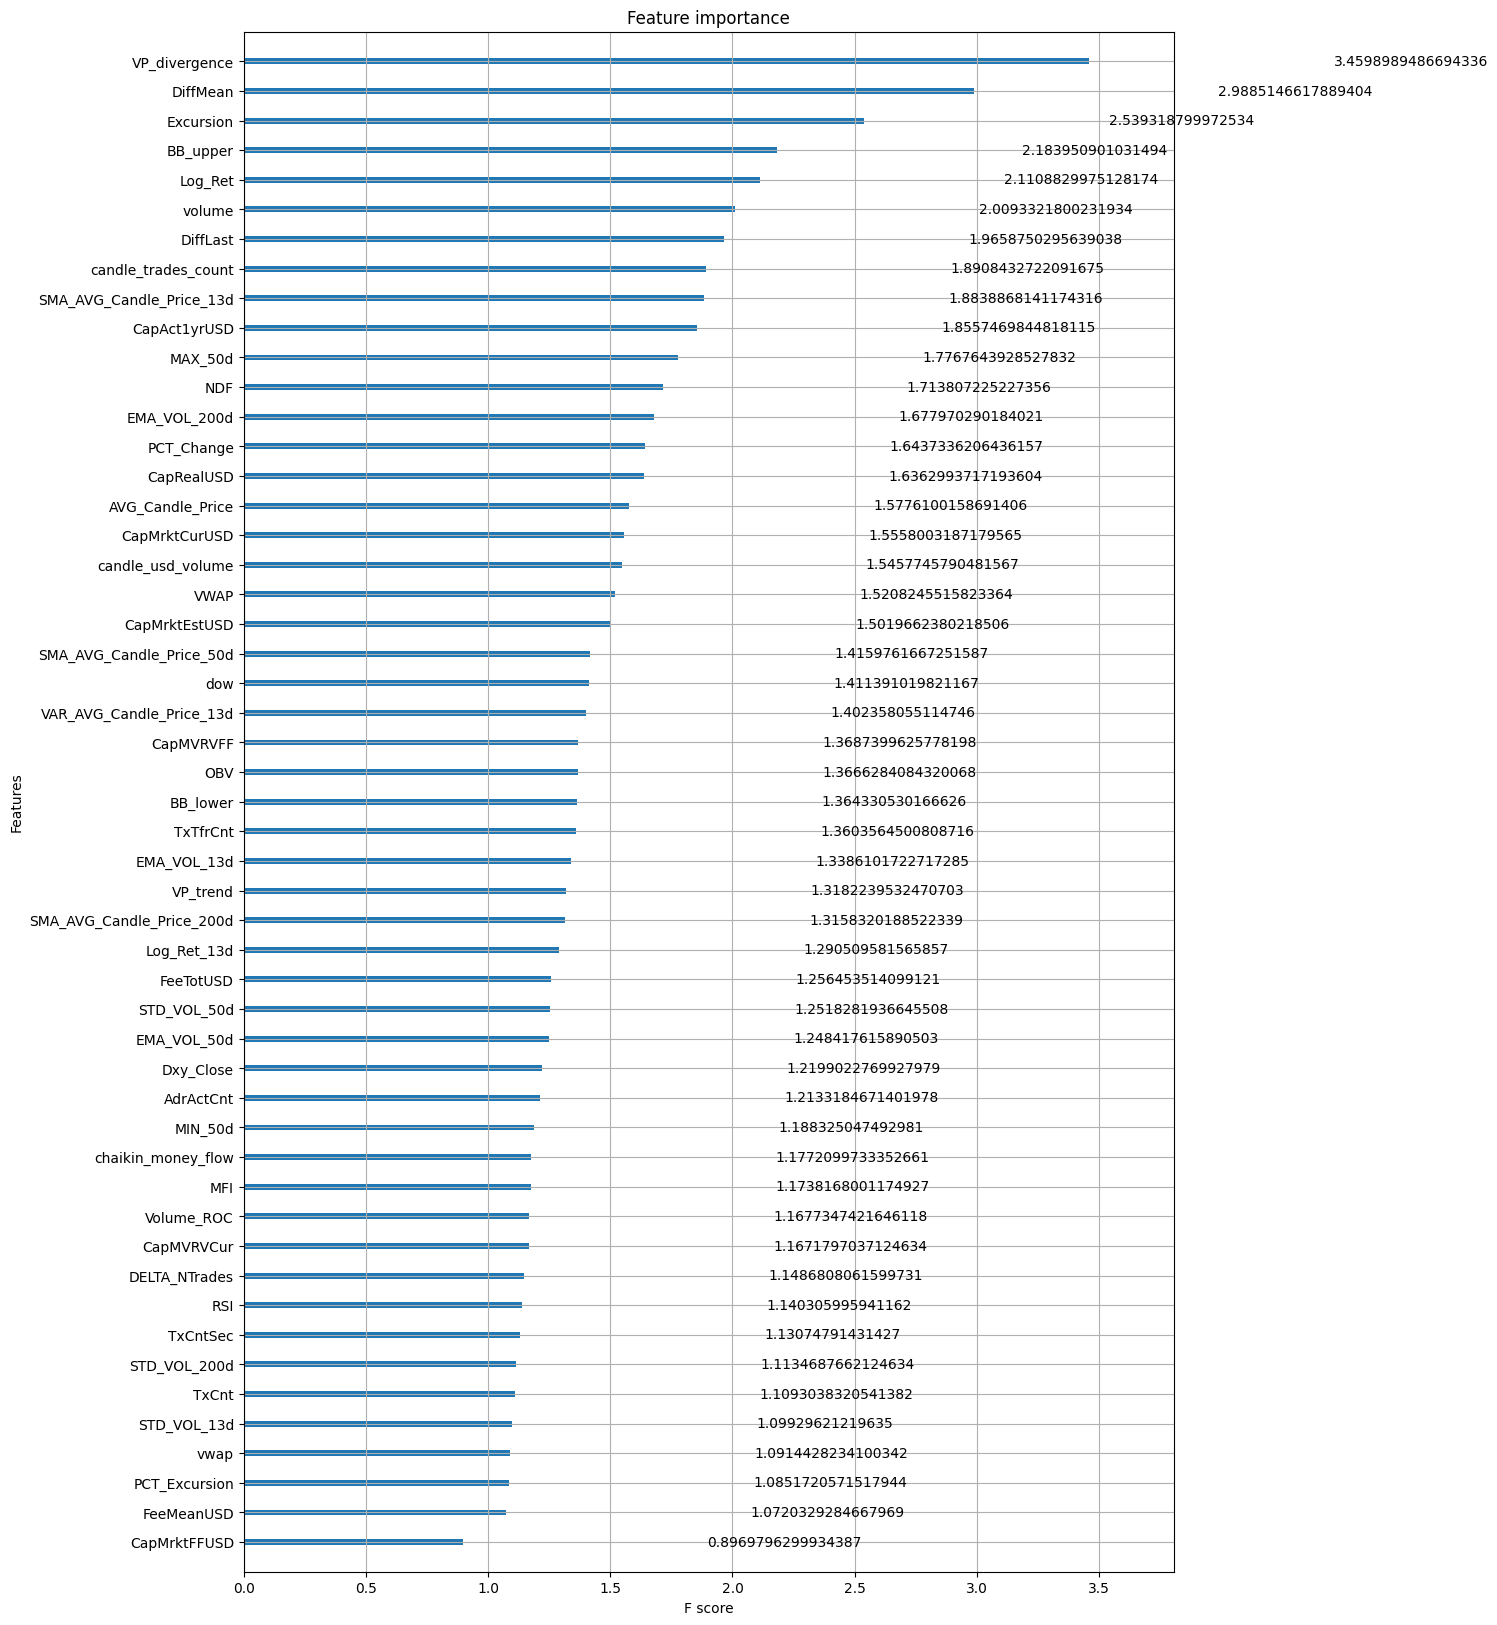

In [158]:
from xgboost import plot_importance

fig, ax = plt.subplots(figsize=(12,20)) 
plot_importance(model, ax=ax, importance_type='gain')
plt.show()

In [159]:
#my_functions.plt_correlation(train)

In [160]:
from sklearn.metrics import fbeta_score

best_precision = 0
thresh = 0
for i in np.arange(0.01, 1, 0.01):
    y_pred = [1 if el > i else 0 for el in y_hat]
    precision = sklearn.metrics.accuracy_score(y, y_pred) # average='weighted', beta=.5)
    #precision = sklearn.metrics.fbeta_score(y, y_pred, average='weighted', beta=.5)
    if best_precision < precision:
        thresh = i 
        best_precision = precision

print(best_precision)
print(thresh)

0.6565656565656566
0.01


In [161]:
y_pred = [1 if el>thresh else 0 for el in y_hat]

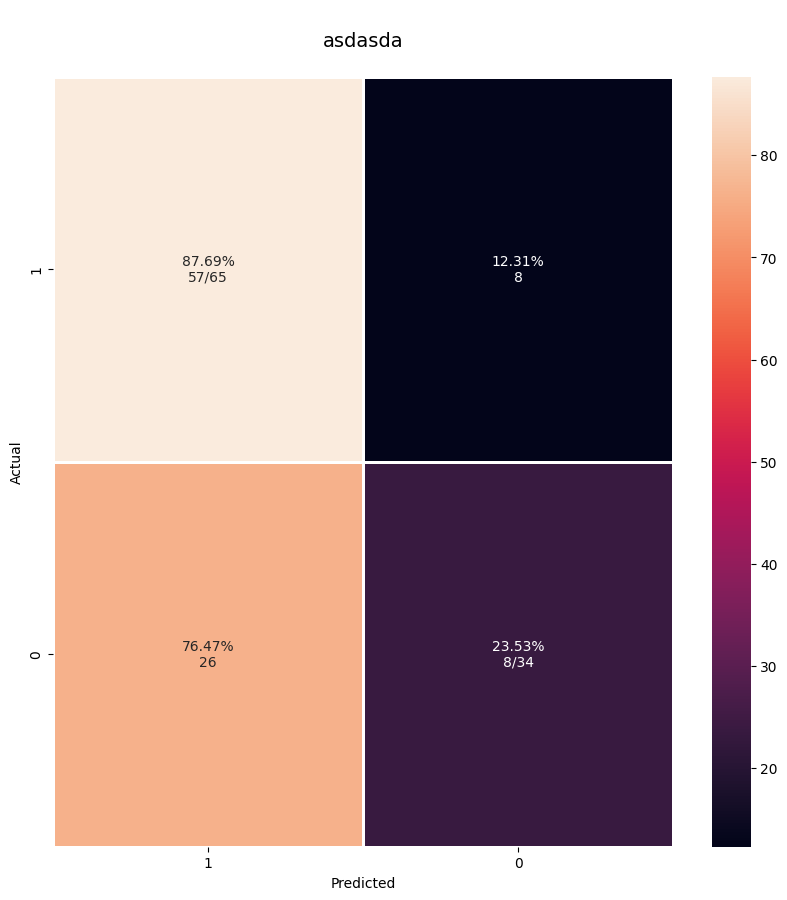

In [162]:
from sklearn.metrics import confusion_matrix

def cm_analysis(
    y_true, 
    y_pred, 
    title: str,
    filename: str, 
    labels: List[str], 
    ymap=None, 
    figsize=(10,10)
) -> None:
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.

    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      title:     plot name
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.

    Returns:
        None
    """

    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.2f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.2f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    cm_perc = pd.DataFrame(cm_perc, index=labels, columns=labels)
    cm_perc.index.name = 'Actual'
    cm_perc.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm_perc, annot=annot, fmt='', linewidths=1, ax=ax)
    plt.title('\n'+title+'\n', fontsize=14)
    plt.show()


cm_analysis(y, y_pred,title='asdasda',filename='cm.png',labels=[1,0])

In [153]:
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(df_test['signal'], y_hat)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
print(auc_test)
y_true = df_test['signal'].to_list()
y_probas = y_hat.tolist()
#skplt.metrics.plot_roc(df_test['signal'],y_probas, title=f"ROC curve, AUC=test: {auc_test:.4f}", classes_to_plot=[1], figsize=(10,10))
#plt.show()

0.6434389140271494
